# Prepare Dataset for Model Training and Evaluating

# Amazon Customer Reviews Dataset

https://s3.amazonaws.com/amazon-reviews-pds/readme.html

## Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

# Checking Pre-Requisites from the Previous Notebooks

In [1]:
%store -r setup_dependencies_passed

In [2]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [3]:
print(setup_dependencies_passed)

True


In [4]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

In [5]:
!aws s3 cp 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [6]:
import csv

df = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)
df.shape

(102084, 15)

In [7]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

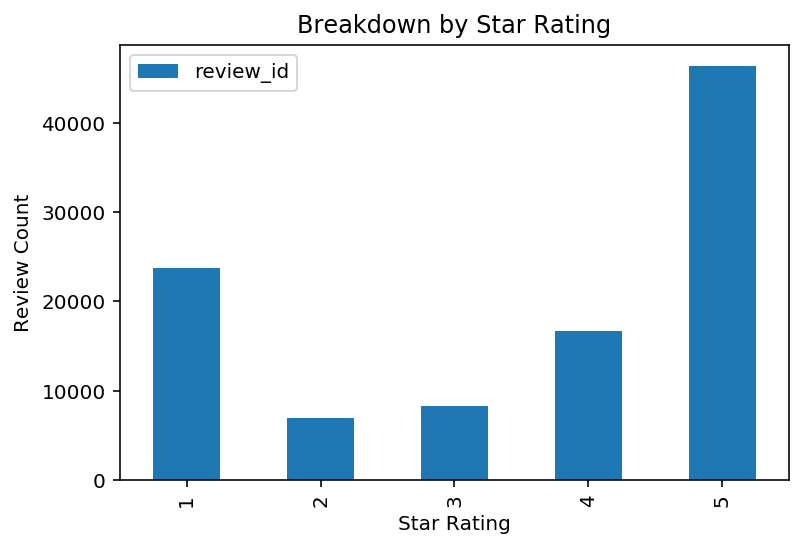

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

# Balance the Dataset

In [9]:
from sklearn.utils import resample

five_star_df = df.query("star_rating == 5")
four_star_df = df.query("star_rating == 4")
three_star_df = df.query("star_rating == 3")
two_star_df = df.query("star_rating == 2")
one_star_df = df.query("star_rating == 1")

# Check which sentiment has the least number of samples
minority_count = min(
    five_star_df.shape[0], four_star_df.shape[0], three_star_df.shape[0], two_star_df.shape[0], one_star_df.shape[0]
)

five_star_df = resample(five_star_df, replace=False, n_samples=minority_count, random_state=27)

four_star_df = resample(four_star_df, replace=False, n_samples=minority_count, random_state=27)

three_star_df = resample(three_star_df, replace=False, n_samples=minority_count, random_state=27)

two_star_df = resample(two_star_df, replace=False, n_samples=minority_count, random_state=27)

one_star_df = resample(one_star_df, replace=False, n_samples=minority_count, random_state=27)

df_balanced = pd.concat([five_star_df, four_star_df, three_star_df, two_star_df, one_star_df])
df_balanced = df_balanced.reset_index(drop=True)

df_balanced.shape

(34450, 15)

Text(0, 0.5, 'Review Count')

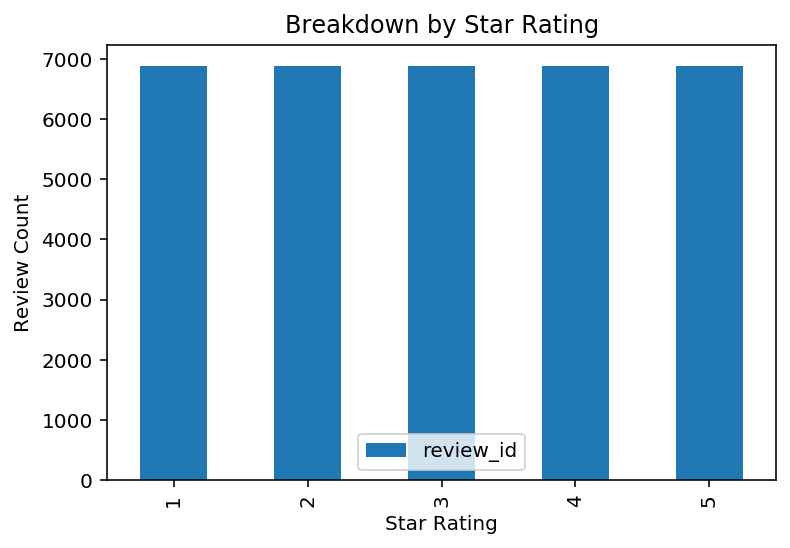

In [10]:
df_balanced[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="Breakdown by Star Rating"
)
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

In [11]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,50930584,R2O4Y7L17EATTI,B008SCNF1S,531153669,Norton Antivirus 2013 - 1 User / 1 PC,Digital_Software,5,0,0,N,Y,great deal - easy to get,I needed an antivirus application and know the...,2013-05-29
1,US,33559471,R3P99W19J4VL4I,B004E9SKEQ,401204792,Microsoft Office Home & Student 2010 - 3PC/1Us...,Digital_Software,5,0,0,N,Y,Great way to keep up to date.,Amazon is providing us a great service by offe...,2014-06-05
2,US,34635641,R3EQ2D5RZF7E4Q,B008SCNLEY,643150354,Norton 360 2013 - 1 User / 3 PC,Digital_Software,5,0,0,N,Y,It works good enough for me.,I bought my 2012 Nortons around the same time ...,2013-10-31
3,US,16625170,R26CNHO8M2EUMN,B00NG7JU4Q,834049942,TurboTax Deluxe Fed + Efile,Digital_Software,5,4,6,N,N,DIY still wins...,"I know, I know... I'm a Mac user who still us...",2014-11-26
4,US,47073366,RD0SSJ3HGIU42,B008SCNLEY,643150354,Norton 360 2013 - 1 User / 3 PC,Digital_Software,5,0,0,N,Y,Easy!,Easy. I used it on 2 devices. I am very please...,2014-06-01


# Split the Data into Train, Validation, and Test Sets

In [12]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["star_rating"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["star_rating"])

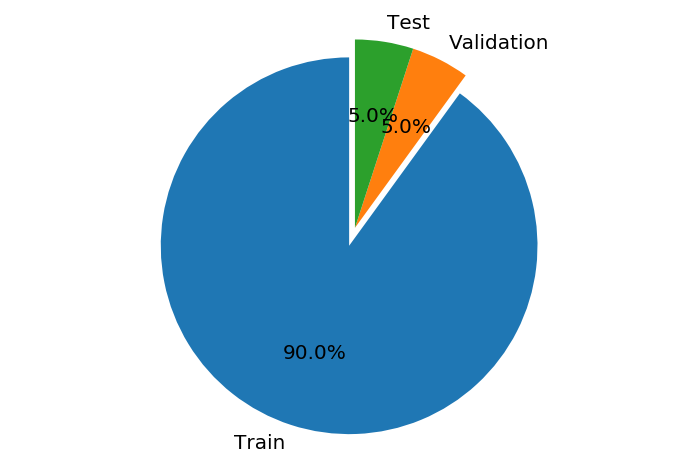

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train Data Split

In [14]:
df_train.shape

(31005, 15)

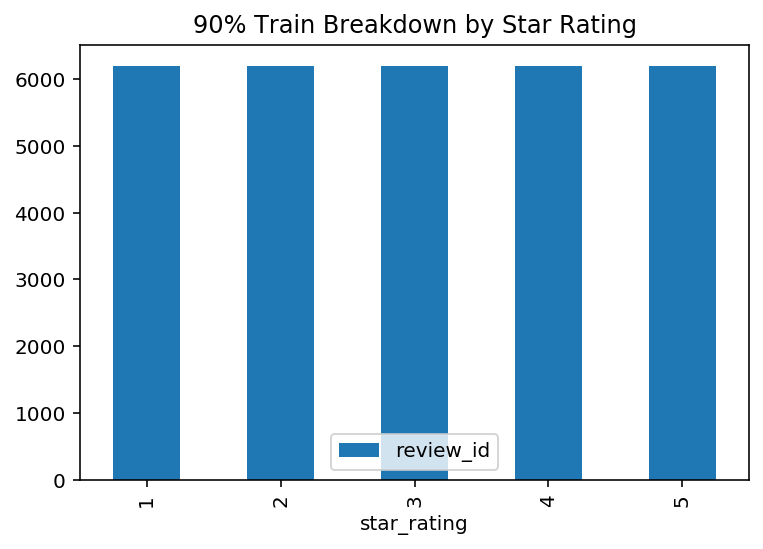

In [15]:
df_train[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="90% Train Breakdown by Star Rating"
)

# Show 5% Validation Data Split

In [16]:
df_validation.shape

(1722, 15)

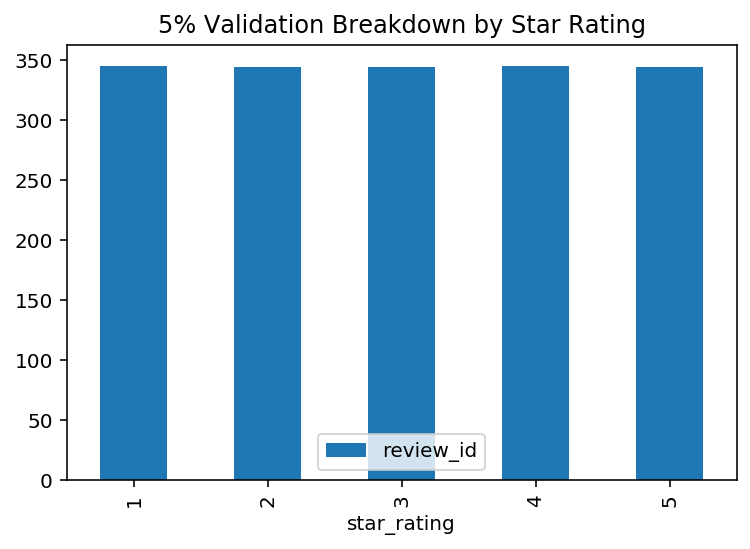

In [17]:
df_validation[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Validation Breakdown by Star Rating"
)

# Show 5% Test Data Split

In [18]:
df_test.shape

(1723, 15)

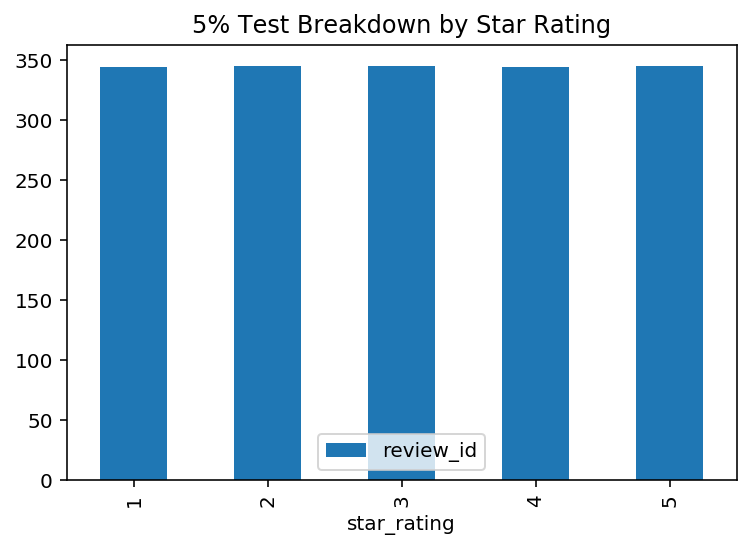

In [19]:
df_test[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Test Breakdown by Star Rating"
)

# Select `star_rating` and `review_body` for Training

In [20]:
df_train = df_train[["star_rating", "review_body"]]
df_train.shape

(31005, 2)

In [21]:
df_train.head(5)

,star_rating,review_body
34298,1,This product did not work for me. The program...
13721,4,Easy to use software. Very organized intervie...
13491,4,Easy to use. I would definitely use again. The...
7483,4,For my purpose the older versions worked for m...
8021,4,Even though I only use this program for my hom...


# Write a Train CSV with Header for Autopilot 

In [22]:
autopilot_train_path = "./amazon_reviews_us_Digital_Software_v1_00_autopilot.csv"
df_train.to_csv(autopilot_train_path, index=False, header=True)

# Upload Train Data to S3 for Autopilot

In [23]:
train_s3_prefix = "data"
autopilot_train_s3_uri = sess.upload_data(path=autopilot_train_path, key_prefix=train_s3_prefix)
autopilot_train_s3_uri

's3://sagemaker-us-east-1-835319576252/data/amazon_reviews_us_Digital_Software_v1_00_autopilot.csv'

In [24]:
!aws s3 ls $autopilot_train_s3_uri

2021-09-15 15:55:37   13679461 amazon_reviews_us_Digital_Software_v1_00_autopilot.csv


# Store Variables for Next Notebook(s)

In [25]:
%store autopilot_train_s3_uri

Stored 'autopilot_train_s3_uri' (str)


In [26]:
%store

Stored variables and their in-db values:
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-835319576252/data/amazon
ingest_create_athena_table_parquet_passed             -> True
pipeline_endpoint_name                                -> 'bert-model-from-registry-ep-1623768224'
pipeline_experiment_name                              -> 'BERT-pipeline-1623459364'
pipeline_name                                         -> 'BERT-pipeline-1623791411'
pipeline_trial_name                                   -> 'trial-1623459435'
s3_private_path_tsv                                   -> 's3://sagemaker-us-east-1-835319576252/amazon-revi
s3_public_path_tsv                                    -> 's3://amazon-reviews-pds/tsv'
setup_dependencies_passed                             -> True
test_data_bias_s3_uri                                 -> 's3://sagemaker-us-east-1-835319576252/bias/test_d
test_data_explainablity_s3_uri                        -> 's3://sagemaker-us-east-1

# Release Resources

In [27]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>